In [1]:
# Imports
import sys
sys.path.insert(1, '/users/wx21978/projects/pion-phys/pi0-analysis/analysis/')
import os
from importlib import reload
import argparse
import copy
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colours
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from python.analysis import (
    EventSelection, Plots, vector, PairSelection, Master, PFOSelection, cross_section,
    CutOptimization, Utils, BeamParticleSelection)
import apps.cex_beam_selection_studies as cbs
from python.analysis import SelectionEvaluation as seval
from python.gnn import DataPreparation, Models, bdt_classifier, Layers
from apps import photon_pairs
from apps.cex_beam_selection_studies import BeamPionSelection
from apps.cex_analysis_input import BeamPionSelection as beam_selection_old
import time
import timeit

2025-11-25 15:38:15.441131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def apply_selections(
        selections: list[str],
        events: Master.Data,
        args : argparse.Namespace | dict,
        is_mc : bool):

    known_selections = [
        "PiBeamSelection", # Pre-selection
        "PandoraTagCut", # Is beam particle track or shower like
        "CaloSizeCut", # Are there reconstructed hits
        "HasFinalStatePFOsCut", # Are there final state particles reconstructed
        "DxyCut", # x-y position
        "DzCut", # z position
        "CosThetaCut", # beam direction
        "APA3Cut", # Remove particles interacting in the 3rd APA
        "MichelScoreCut", # Does it look like a decaying muon?
        "MichelScoreCutChargeWeight", # Does it look like a decaying muon with some fancy weighting?
        "MedianDEdXCut", # Average energy deposition of the particle
        "BeamScraperCut", # Is it a beam scraper event?
        ]
    
    args_c = Utils.args_to_dict(args)

    events_copy = events.Filter(returnCopy = True)
    if is_mc:
        selection_args = "mc_arguments"
        sample = "mc"
    else:
        selection_args = "data_arguments"
        sample = "data"

    if "beam_selection_masks" in args_c:
        for s in selections:
            mask = args_c["all_beam_selections"]["selections"][s](events_copy, **args_c["all_beam_selections"][selection_args][s])
            events_copy.Filter([mask], [mask])
            print(events_copy.cutTable.get_table())
    return events_copy

In [6]:
list(args.all_beam_selections.keys())

['selections', 'mc_arguments', 'data_arguments']

In [10]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(
    "/users/wx21978/projects/pion-phys/analyses/project_3GeV/sample_analysis_3GeV.json"))

sample = "mc"
s_index = 0
evts_mc_0 = Master.Data(args.ntuple_files[sample][s_index]["file"],
                        nTuple_type=args.ntuple_files[sample][s_index]["type"],
                        target_momentum=args.ntuple_files[sample][s_index]["pmom"])

evts_full_sel = BeamPionSelection(evts_mc_0, args, True)

evts_sel_manual = apply_selections(["PiBeamSelection", "PandoraTagCut", "CaloSizeCut", "APA3Cut"],
                                   evts_mc_0, args, True)

'BeamPionSelection' executed in 0.0181s

           Name  Remaining events  Percentage of total events remaining  \
0  Initial data             91237                            100.000000   
1             -             72019                             78.936177   

   Relative percentage events  Remaining PFOs  \
0                  100.000000          379943   
1                   78.936177          313800   

   Percentage of total PFOs remaining  Relative percentage of PFOs  \
0                          100.000000                   100.000000   
1                           82.591336                    82.591336   

   Average PFOs per event  
0                4.164352  
1                4.357184  
           Name  Remaining events  Percentage of total events remaining  \
0  Initial data             91237                            100.000000   
1             -             72019                             78.936177   
2             -             61159                             67.033112   

   Relative percentage events 

(array([7.4670e+03, 0.0000e+00, 0.0000e+00, 2.7824e+04, 5.7300e+03,
        1.3550e+03, 8.6000e+02, 6.8800e+02, 4.9200e+02, 4.0700e+02,
        3.2700e+02, 2.9100e+02, 2.4600e+02, 2.1100e+02, 1.5400e+02,
        1.6500e+02, 1.3000e+02, 1.1600e+02, 9.9000e+01, 9.0000e+01,
        8.0000e+01, 6.4000e+01, 7.0000e+01, 7.1000e+01, 6.1000e+01,
        5.1000e+01, 6.0000e+01, 4.9000e+01, 4.0000e+01, 3.1000e+01,
        3.0000e+01, 4.1000e+01, 3.0000e+01, 2.7000e+01, 3.0000e+01,
        2.1000e+01, 2.5000e+01, 2.0000e+01, 2.3000e+01, 2.0000e+01,
        1.3000e+01, 1.4000e+01, 1.2000e+01, 1.6000e+01, 5.0000e+00,
        1.1000e+01, 1.2000e+01, 1.0000e+01, 1.0000e+01, 5.0000e+00,
        1.4000e+01, 1.1000e+01, 8.0000e+00, 6.0000e+00, 7.0000e+00,
        5.0000e+00, 4.0000e+00, 5.0000e+00, 6.0000e+00, 4.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 5.0000e+00, 2.0000e+00,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 2.00

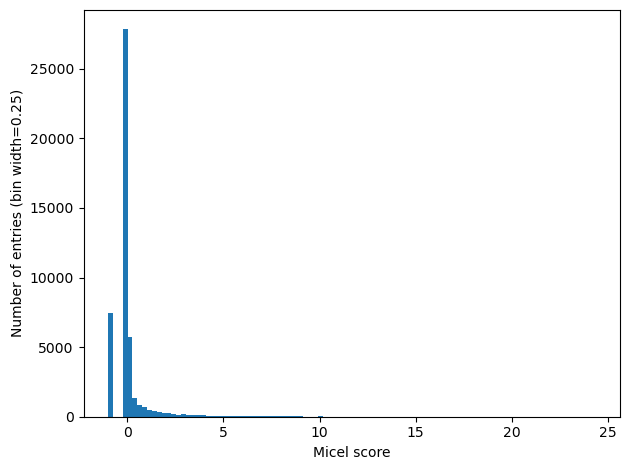

In [11]:
Plots.PlotHist(evts_sel_manual.recoParticles.beam_michelScore, xlabel = "Micel score")